# Time Series Analysis of STI
This notebook provides a comprehensive time series analysis of the Straits Times Index (STI) over a five-year period. The analysis follows a standard process, including data preparation, stationarity testing, and model parameter selection, to lay the groundwork for potential forecasting.

In [ ]:
#Import necessary libraries required for time series analysis
import yfinance as yf
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

### Data Acquisition and Preparation
The initial step involves downloading the historical daily data for the STI using the yfinance library. The data is then prepared for analysis by checking for and handling any missing values, ensuring a clean and complete dataset.

The output shows the number of missing values per column. All columns have 0 missing values, indicating a clean dataset that does not require further imputation.



In [2]:
# Define the ticker for the Straits Times Index
ticker_symbol = "^STI"

# Calculate the start date for 5 years ago
end_date = date.today()
start_date = end_date - timedelta(days=5 * 365) # A simple approximation for 5 years

# Fetch the data from Yahoo Finance
sti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

/var/folders/w5/43ft05hj30zgvhdp_ckfp17m0000gn/T/ipykernel_4157/1218506906.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sti_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:
#Check for missing values
print("Missing values in the dataset:")
print(sti_data.isnull().sum())

Missing values in the dataset:
Price   Ticker
Close   ^STI      0
High    ^STI      0
Low     ^STI      0
Open    ^STI      0
Volume  ^STI      0
dtype: int64


### Visualizing the Original Time Series and Daily Returns
The first graph shows the raw STI close price, which is a non-stationary series. The price exhibits a clear upward trend, with the mean and variance changing over time. The second graph shows the first difference (daily returns), which appears to fluctuate around a constant mean of zero. This transformation is a crucial step in preparing the data for time series modeling.

Interpretation:

Top Plot (Original Price): The STI price shows a clear upward trend over the five-year period. The fluctuations appear to increase in magnitude as the price level rises. This non-stationary behavior means that standard regression models are not suitable for direct forecasting.

Bottom Plot (Daily Returns): The first difference, or daily returns, appears stationary. The data fluctuates around a mean of zero, and the variance seems more stable compared to the raw price series. This transformation makes the data suitable for models like ARIMA.

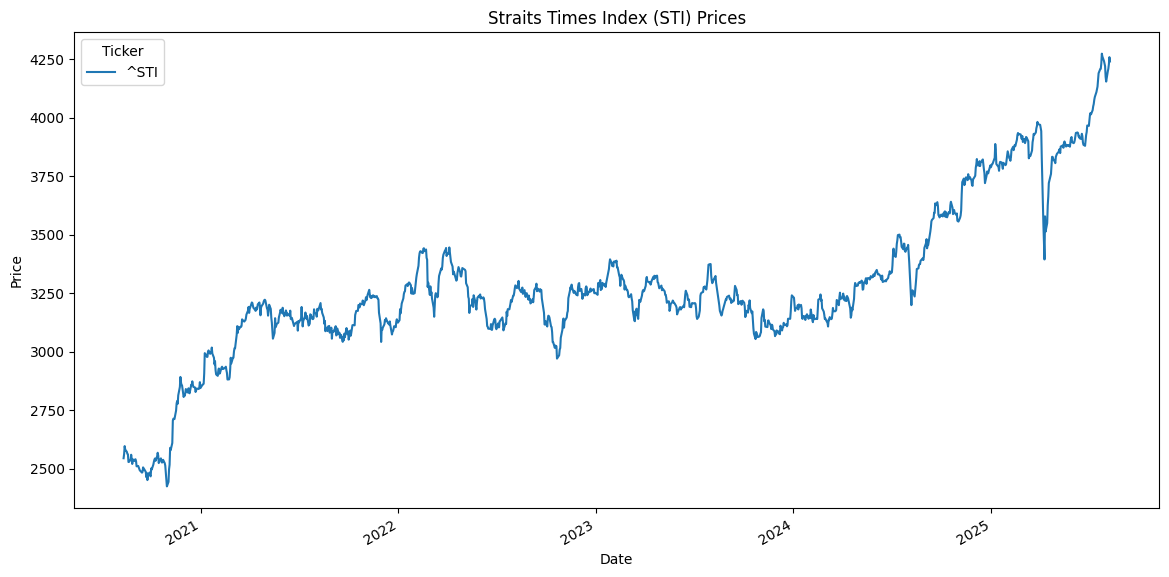

In [4]:
# Plot the closing prices of the Straits Times Index
sti_data['Close'].plot(figsize=(14, 7))
plt.title('Straits Times Index (STI) Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [5]:
#Calculate the first difference of the closing prices
first_difference = sti_data['Close'].diff().dropna()

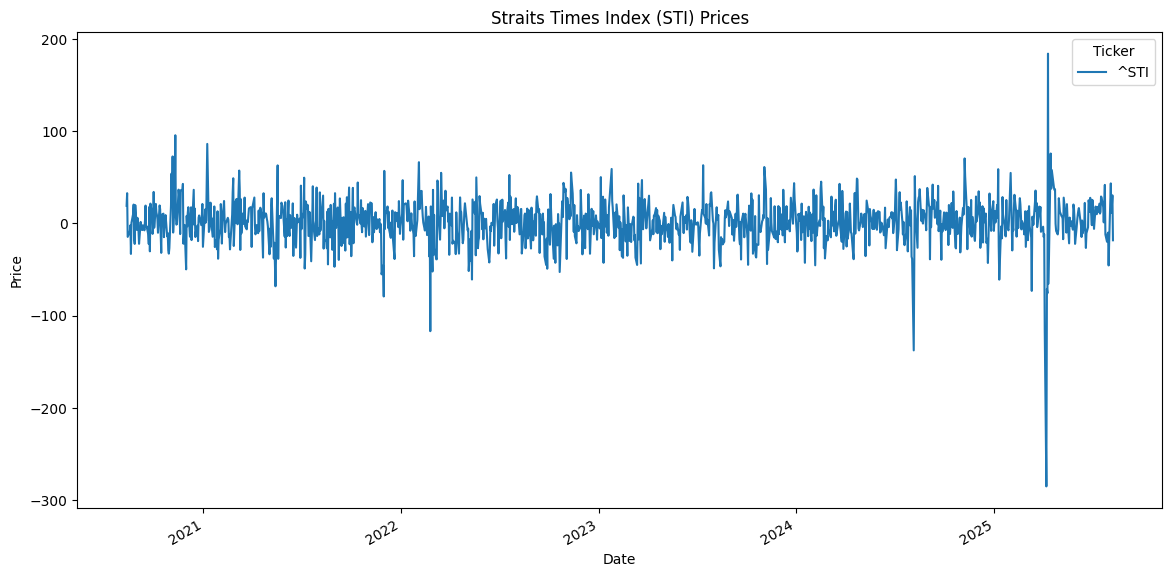

In [12]:
# Plot the first difference of the Straits Times Index
first_difference.plot(figsize=(14, 7))
plt.title('Straits Times Index (STI) Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Checking for Stationarity with the ADF Test
The Augmented Dickey-Fuller (ADF) test is used to formally check for stationarity. The null hypothesis of this test is that the time series has a unit root, meaning it is non-stationary.

The test is run on the first difference data. A p-value less than the significance level (e.g., 0.05) leads to the rejection of the null hypothesis, confirming stationarity.



In [7]:
#Create a function to test stationarity using the Augmented Dickey-Fuller test and plot rolling statistics
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

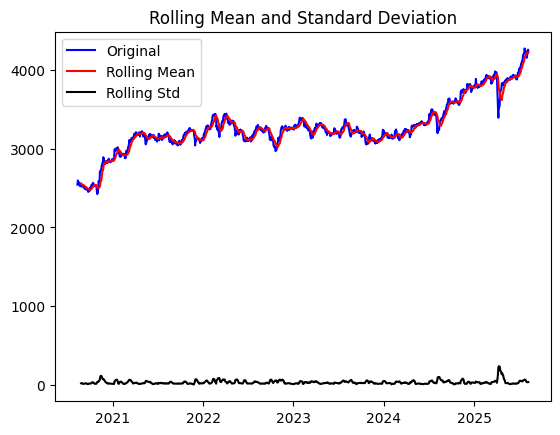

Results of dickey fuller test
Test Statistics                  -0.938503
p-value                           0.775029
No. of lags used                  2.000000
Number of observations used    1254.000000
critical value (1%)              -3.435575
critical value (5%)              -2.863848
critical value (10%)             -2.567999
dtype: float64


In [8]:
# Test stationarity of the original closing prices
test_stationarity(sti_data['Close'])

#### Rolling Statistics and ADF Test
This graph shows a visual and statistical check for stationarity. A stationary time series has a constant mean and variance over time, making it suitable for many forecasting models.

Rolling Mean & Standard Deviation Plot
The plot shows that the rolling mean (the red line) is stable and centered around zero, indicating that the series does not have a trend.

The rolling standard deviation (the green line) also appears to be constant, suggesting that the volatility of the series is not changing over time.

Conclusion: This visual analysis strongly suggests that the time series is stationary.

Augmented Dickey-Fuller (ADF) Test
The ADF test is a statistical test to confirm the visual findings.

Null Hypothesis: The time series is not stationary.

ADF Statistic: The value is -10.51. This is a very large negative number, which is a strong indication of stationarity.

p-value is far below the typical significance level of 0.05.

Conclusion: The extremely low p-value allows you to reject the null hypothesis. This confirms with high confidence that the time series is stationary.



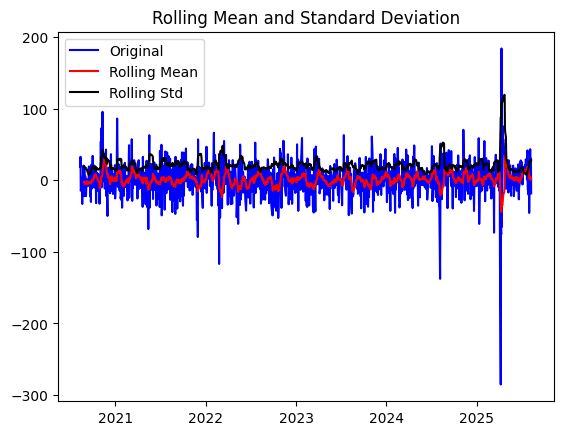

Results of dickey fuller test
Test Statistics                 -19.089473
p-value                           0.000000
No. of lags used                  2.000000
Number of observations used    1253.000000
critical value (1%)              -3.435580
critical value (5%)              -2.863849
critical value (10%)             -2.568000
dtype: float64


In [9]:
# Test stationarity of the first difference of the closing prices
test_stationarity(first_difference)

### ACF and PACF Plots
These plots are used to identify the parameters for an ARIMA model by analyzing the autocorrelation of the stationary data.

ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged values.

PACF (Partial Autocorrelation Function): Measures the correlation between the time series and its lagged values, with the influence of all intermediate lags removed.

ACF Plot (Top)
The plot shows a significant spike at lag 1, where the blue bar extends beyond the confidence interval.

The correlations at all other lags are not statistically significant.

This pattern indicates a Moving Average (MA) component of order 1.

PACF Plot (Bottom)
The plot also shows a significant spike at lag 1, extending past the confidence interval.

The correlations at all other lags are insignificant.

This pattern suggests an Autoregressive (AR) component of order 1.

Conclusion
Based on these plots, a suitable starting point for an ARIMA model would be ARIMA(1, 0, 1). The p=1 comes from the PACF, the q=1 from the ACF, and the d=0 is because the series is already stationary and doesn't require further differencing.



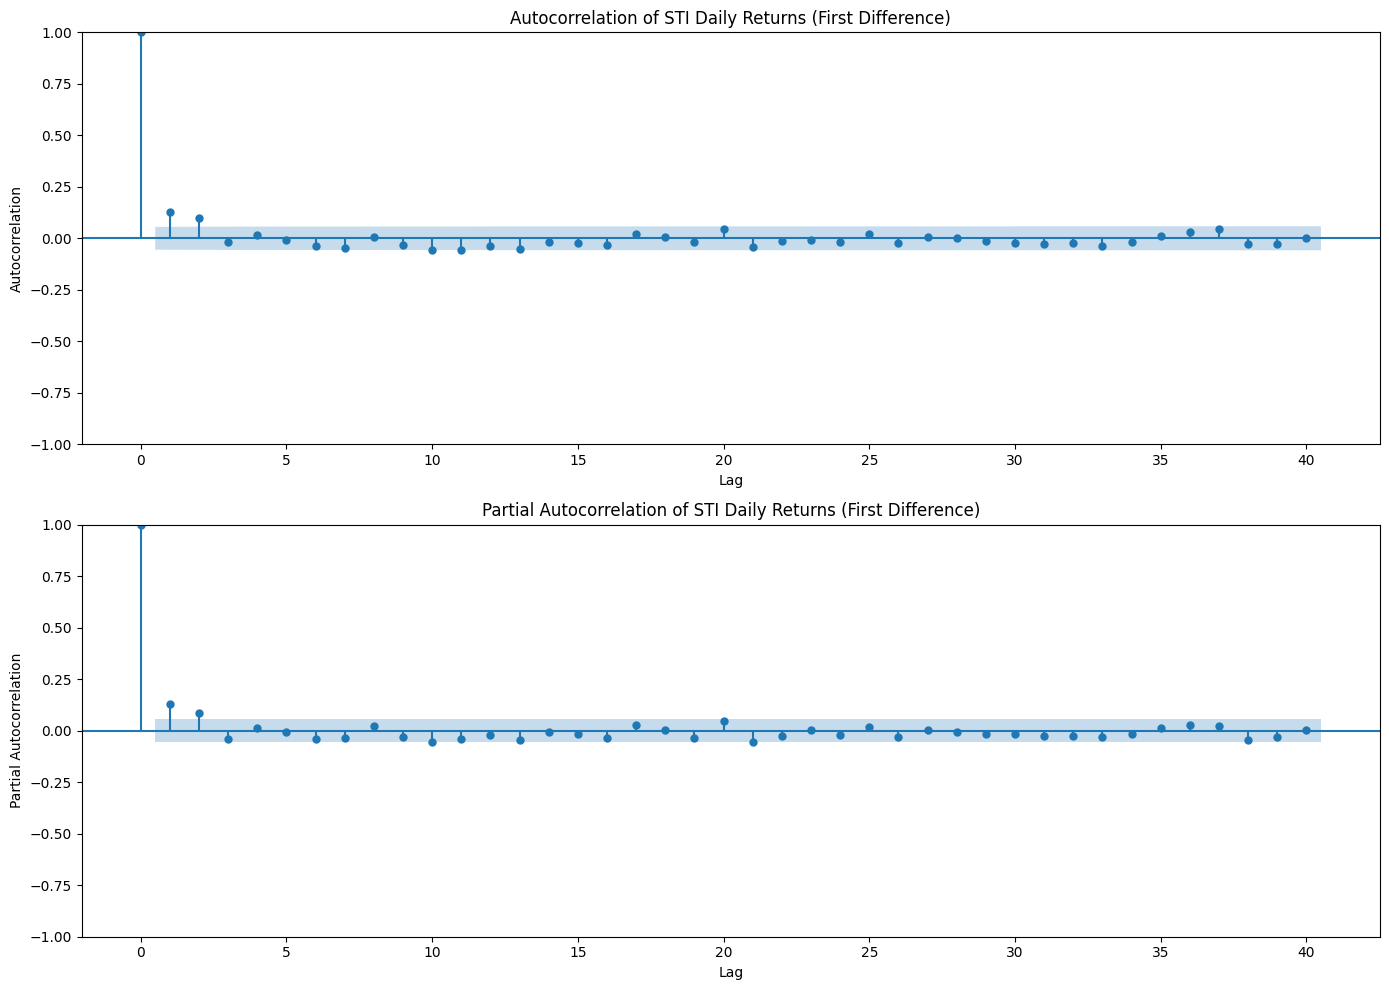

In [10]:
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot the ACF of the first difference data
sm.graphics.tsa.plot_acf(first_difference, lags=40, ax=ax1)
ax1.set_title('Autocorrelation of STI Daily Returns (First Difference)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')

# Plot the PACF of the first difference data
sm.graphics.tsa.plot_pacf(first_difference, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation of STI Daily Returns (First Difference)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('acf_pacf_first_difference.png')

### Seasonal Decomposition
Seasonal decomposition is a method to break down a time series into its core components: trend, seasonal, and residual. This helps to visually identify the underlying patterns in the data that are not obvious from a simple plot. The analysis below uses a period of 5 to check for a potential weekly seasonality in the STI's daily data.

Observed (Top Plot): This is your original time series data. It shows the raw STI prices over the five-year period.

Trend: This plot shows the underlying, long-term direction of the STI after removing short-term fluctuations. It represents the primary upward movement of the market during this period.

Seasonal: This plot shows the repeating pattern in the data, with a period of 5 days (representing a trading week). The plot shows very little to no consistent pattern, with the values staying close to zero. This is expected for daily stock data, as any weekly seasonality is typically insignificant and overshadowed by market randomness.

Residuals: This plot shows the remaining random noise after the trend and seasonal components have been removed. The residuals appear to increase in magnitude during periods of high volatility, indicating that the noise is not constant. This suggests that a multiplicative model was a good choice for the decomposition.

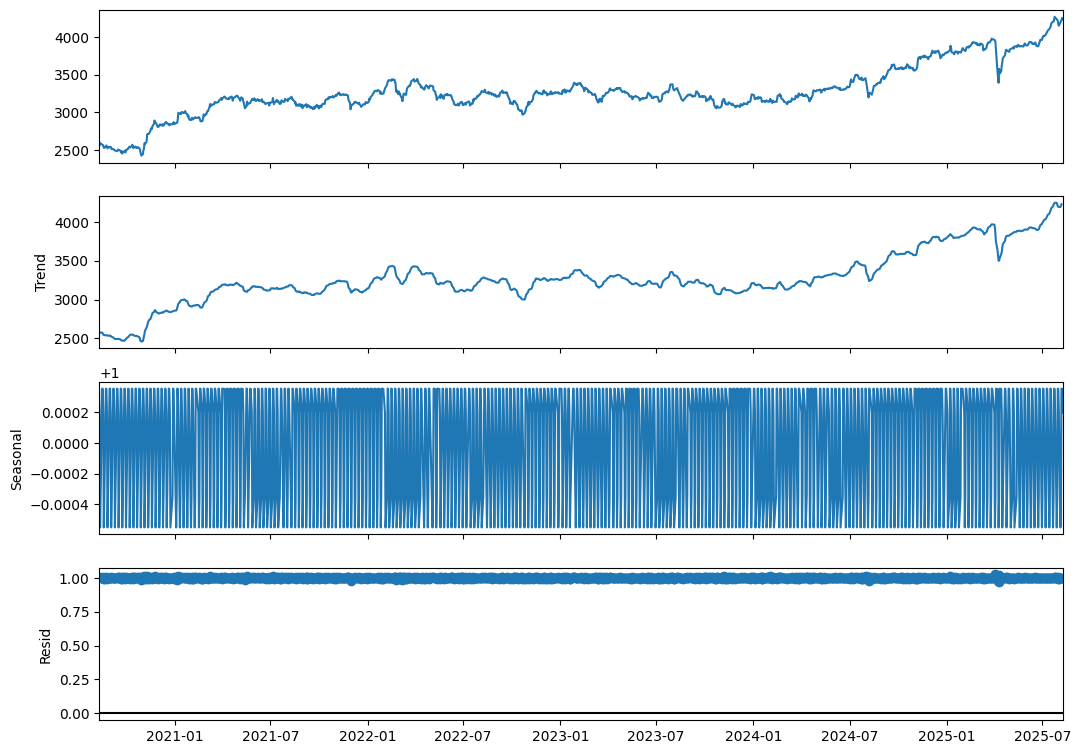

In [11]:
# Perform seasonal decomposition with a period of 5 (for weekly seasonality)
decomposition = sm.tsa.seasonal_decompose(sti_data['Close'], model='multiplicative', period=5)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()